# Kurakin et al., 2017 - Replication

This Notebook aims at replicating the results of Kurakin et al., 2017 paper "ADVERSARIAL EXAMPLES IN THE PHYSICAL WORLD" and experimenting with the concept introduced there. Despite the name of the paper, the notebook focuses on the methods strictly in the "virtual world".

## Imports

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from train_mnist import Net
from fgsm import ll_fgsm, replacement_pipeline

## Constants

In [2]:
EPS = np.array([0, .05, .1, .15, .2, .25, .3], dtype=np.float32)
BATCH_SIZE = 500
DEVICE = 'mps' if getattr(torch, 'has_mps', False) else 'cpu' # device to run the model on


SIMPLE_MODEL1 = 'trained_models/mnist_cnn_best_1672124664.pt'
SIMPLE_MODEL2 = 'trained_models/mnist_cnn_best_1672286365.pt'

In [3]:
# Load data
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./dataset', train=False, download=True, transform=transform)

test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle':False}
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

## Experiments

### Basic experiment utils

In [4]:
def perform_exp(model, model2, test_loader, alt_target=None):
    epsilons = EPS
    epsilons5d = epsilons.reshape((-1, 1, 1, 1, 1))
    # Accuracy counter
    correct = np.zeros(epsilons.shape, dtype=np.int32)
    bl_correct = np.zeros(epsilons.shape, dtype=np.int32)
    adv_examples = [[] for _ in epsilons]

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1)[1]  # get the index of the max log-probability

        # Call FGSM Attack
        alt_targets = None
        if alt_target:
            alt_targets = torch.ones_like(target) * alt_target
        perturbed_data = ll_fgsm(data, epsilons5d, 1, model, DEVICE, targets=alt_targets)
        d1, d2, d3, d4, d5 = perturbed_data.shape
        perturbed_data = perturbed_data.reshape((-1, d3, d4, d5))
        
        # Re-classify the perturbed image
        if model2:
            outputs = model2(perturbed_data)
        else:
            outputs = model(perturbed_data)
        outputs = outputs.reshape((d1, d2, -1))
        perturbed_data = perturbed_data.reshape((d1, d2, d3, d4, d5))
            
        # Naive attack
        bl_data = replacement_pipeline(data, target, epsilons5d, 1, model, DEVICE)
        bl_data = bl_data.reshape((-1, d3, d4, d5))
        
        # Re-classify the Naive attack image
        if model2:
            bl_outputs = model2(bl_data)
        else:
            bl_outputs = model(bl_data)
        bl_outputs = bl_outputs.reshape((d1, d2, -1))
        bl_data = bl_data.reshape((d1, d2, d3, d4, d5))

        # Check for success
        final_preds = outputs.max(2)[1]  # get the index of the max log-probability
        
        for i in range(len(epsilons)):
            correct[i] += final_preds[i].eq(target.view_as(final_preds[i])).sum().item()
            
            if len(adv_examples[i]) == 5:
                continue
            for j in range(len(target)):
                if final_preds[i][j].item() == target[j].item():
                    # Special case for saving 0 epsilon examples
                    if (epsilons[i] == 0) and (len(adv_examples[i]) < 5):
                        adv_ex = perturbed_data[i][j].squeeze().detach().cpu().numpy()
                        adv_examples[i].append((init_pred[j].item(), final_preds[i][j].item(), adv_ex))
                else:
                    # Save some adv examples for visualization later
                    if len(adv_examples[i]) < 5:
                        adv_ex = perturbed_data[i][j].squeeze().detach().cpu().numpy()
                        adv_examples[i].append((init_pred[j].item(), final_preds[i][j].item(), adv_ex))
                
        bl_final_preds = bl_outputs.max(2)[1]  # get the index of the max log-probability
        for i in range(len(epsilons)):
            bl_correct[i] += bl_final_preds[i].eq(target.view_as(bl_final_preds[i])).sum().item()

    # Calculate final accuracy for this epsilon
    final_acc = correct / len(test_loader.dataset)
    
    # For naive approach
    bl_final_acc = bl_correct / len(test_loader.dataset)
    
    for i, epsilon in enumerate(epsilons):
        print(f'Epsilon: {epsilon: .2g}\tLL-FGSM\tTest Accuracy = {correct[i]}/{len(test_loader.dataset)} = {final_acc[i]}')
        print(f'Epsilon: {epsilon: .2g}\tFGSM\tTest Accuracy = {bl_correct[i]}/{len(test_loader.dataset)} = {bl_final_acc[i]}')

    # Return the accuracy and an adversarial example
    return final_acc, bl_final_acc, adv_examples

def analyze_errors(model, test_loader, epsilon, alt_target=None):
    pred_mat = np.zeros((10, 10), dtype=np.int32)
    # Loop over all examples in test set
    for data, target in test_loader:    
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Call FGSM Attack
        alt_targets = None
        if alt_target:
            alt_targets = torch.ones_like(target) * alt_target
        perturbed_data = ll_fgsm(data, epsilon, 1, model, DEVICE, targets=alt_targets)        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1)[1]
        
        for j in range(len(target)):
            pred_mat[target[j].item()][final_pred[j]] += 1
    
    return pred_mat  

In [5]:
def plot_acc_graph(accuracies, bl_accuracies, label1='FGSM', label2='Naive'):
    plt.figure(figsize=(5, 5))
    plt.plot(EPS, accuracies, '*-', label=label1)
    plt.plot(EPS, bl_accuracies, '^-', label=label2)
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title('Accuracy vs Epsilon')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_examples(examples):
    # Plot several examples of adversarial samples at each epsilon
    cnt = 0
    plt.figure(figsize=(8, 10))
    for i in range(len(EPS)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(EPS), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f'Eps: {EPS[i]: .2g}', fontsize=14)
            orig, adv, ex = examples[i][j]
            plt.title(f'{orig} -> {adv}')
            plt.imshow(ex, cmap='gray')
    plt.tight_layout()
    plt.show()
    
def plot_error_mat(error_mat):
    labels = np.arange(10)
    sns.heatmap(error_mat, annot=True, xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":6})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### *Experiment 1 - LL FGSM*

Here the least likely (LL) label will be used to create the noise. While in the paper this was only used in the iterative method, here the concept would first be checked on its own.

In [6]:
# Load first simple trained model
smodel1 = Net().to(DEVICE)
smodel1.load_state_dict(torch.load(SIMPLE_MODEL1))
_ = smodel1.eval()

Epsilon:  0	LL-FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0	FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0.05	LL-FGSM	Test Accuracy = 9587/10000 = 0.9587
Epsilon:  0.05	FGSM	Test Accuracy = 9131/10000 = 0.9131
Epsilon:  0.1	LL-FGSM	Test Accuracy = 5351/10000 = 0.5351
Epsilon:  0.1	FGSM	Test Accuracy = 5819/10000 = 0.5819
Epsilon:  0.15	LL-FGSM	Test Accuracy = 1588/10000 = 0.1588
Epsilon:  0.15	FGSM	Test Accuracy = 2257/10000 = 0.2257
Epsilon:  0.2	LL-FGSM	Test Accuracy = 1172/10000 = 0.1172
Epsilon:  0.2	FGSM	Test Accuracy = 1342/10000 = 0.1342
Epsilon:  0.25	LL-FGSM	Test Accuracy = 1135/10000 = 0.1135
Epsilon:  0.25	FGSM	Test Accuracy = 1174/10000 = 0.1174
Epsilon:  0.3	LL-FGSM	Test Accuracy = 1135/10000 = 0.1135
Epsilon:  0.3	FGSM	Test Accuracy = 1136/10000 = 0.1136


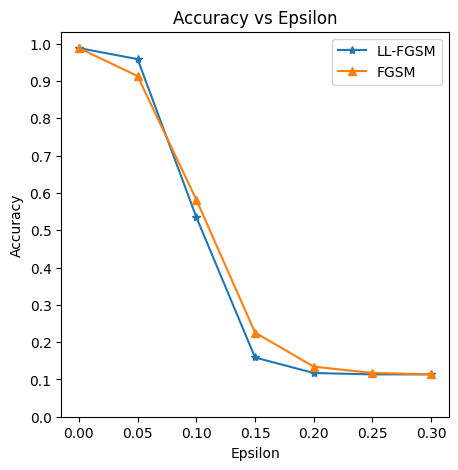

In [7]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies, label1='LL-FGSM', label2='FGSM')

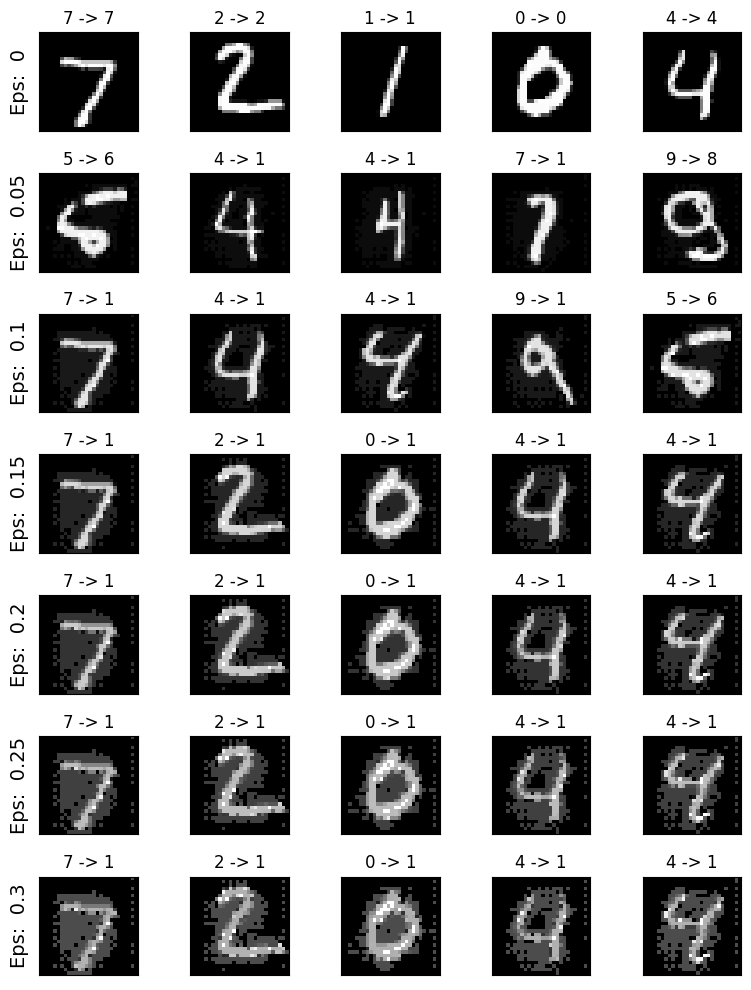

In [8]:
plot_examples(examples)

In [9]:
error_mat = analyze_errors(smodel1, test_loader, 0.15)

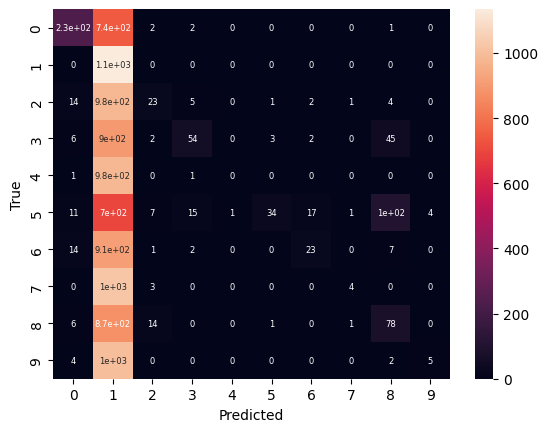

In [10]:
plot_error_mat(error_mat)

The LL-FGSM attack doesn't seem to be more efficient than the original FGSM on this problem, suggesting that it may be required to use a more complex dataset.

### *Experiment 2 - Pushing prediction is a specific direction*

Instead of choosing the least likely prediction, the direction of the noise is manually chosen to be to the prediction of 5 (chosen arbitrarily). The expectation is that we the common prediction would be 5.

Epsilon:  0	LL-FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0	FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0.05	LL-FGSM	Test Accuracy = 9569/10000 = 0.9569
Epsilon:  0.05	FGSM	Test Accuracy = 9131/10000 = 0.9131
Epsilon:  0.1	LL-FGSM	Test Accuracy = 6238/10000 = 0.6238
Epsilon:  0.1	FGSM	Test Accuracy = 5819/10000 = 0.5819
Epsilon:  0.15	LL-FGSM	Test Accuracy = 3019/10000 = 0.3019
Epsilon:  0.15	FGSM	Test Accuracy = 2257/10000 = 0.2257
Epsilon:  0.2	LL-FGSM	Test Accuracy = 2245/10000 = 0.2245
Epsilon:  0.2	FGSM	Test Accuracy = 1342/10000 = 0.1342
Epsilon:  0.25	LL-FGSM	Test Accuracy = 2097/10000 = 0.2097
Epsilon:  0.25	FGSM	Test Accuracy = 1174/10000 = 0.1174
Epsilon:  0.3	LL-FGSM	Test Accuracy = 2072/10000 = 0.2072
Epsilon:  0.3	FGSM	Test Accuracy = 1136/10000 = 0.1136


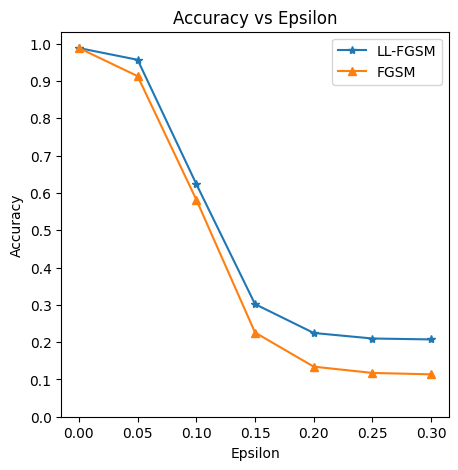

In [11]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, None, test_loader, alt_target=5)
plot_acc_graph(accuracies, bl_accuracies, label1='LL-FGSM', label2='FGSM')

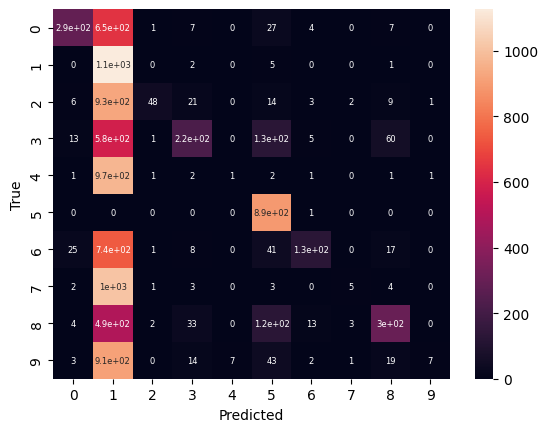

In [12]:
error_mat = analyze_errors(smodel1, test_loader, 0.15, alt_target=5)
plot_error_mat(error_mat)

Interestingly, even deciding to push the prediction towards some arbitrary prediction, had a small effect on the final prediction and the prediction of "1" was still overwhelming.

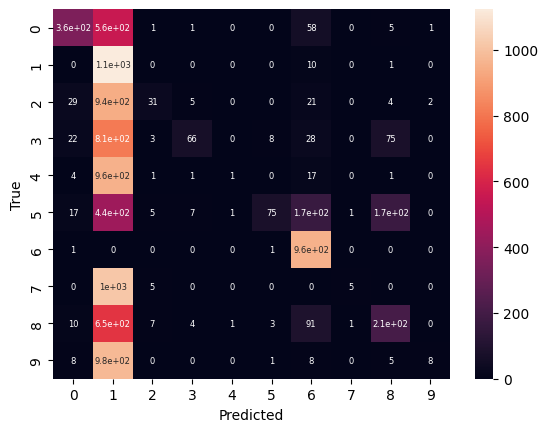

In [13]:
error_mat = analyze_errors(smodel1, test_loader, 0.15, alt_target=6)
plot_error_mat(error_mat)

Another attempt with 6 doesn't seem to make much difference, perhaps because there are more nuances in the multi-dimensional representation than can be intuitively expected.